# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch04/ch04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-10-27 06:22:23--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-10-27 06:22:23 (27.0 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2'
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] numpy 1.23.5
[OK] matplotlib 3.7.1
[OK] sklearn 1.2.2
[OK] pandas 1.5.3


# 4장 - 좋은 훈련 데이터셋 만들기 – 데이터 전처리


### 목차

- 누락된 데이터 다루기
  - 테이블 형태 데이터에서 누락된 값 식별
  - 누락된 값이 있는 샘플이나 특성 제외
  - 누락된 값 대체
  - 사이킷런 추정기 API 익히기
- 범주형 데이터 다루기
  - 판다스를 사용한 범주형 데이터 인코딩
  - 순서가 있는 특성 매핑
  - 클래스 레이블 인코딩
  - 순서가 없는 특성에 원-핫 인코딩 적용
  - 순서가 있는 특성 인코딩하기
- 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기
- 특성 스케일 맞추기
- 유용한 특성 선택
  - 모델 복잡도 제한을 위한 L1 규제와 L2 규제
  - L2 규제의 기하학적 해석
  - L1 규제를 사용한 희소성
  - 순차 특성 선택 알고리즘
- 랜덤 포레스트의 특성 중요도 사용
- 요약

In [3]:
from IPython.display import Image
%matplotlib inline

# 누락된 데이터 다루기


## 테이블 형태 데이터에서 누락된 값 식별


In [4]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# 파이썬 2.7을 사용하는 경우
# 다음과 같이 문자열을 유니코드로 변환해야 합니다:
if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [5]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [6]:
# `values` 속성으로 넘파이 배열을 얻을 수 있습니다
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

## 누락된 값이 있는 샘플이나 특성 제외


In [7]:
# 누락된 값이 있는 행을 삭제합니다
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [8]:
# 누락된 값이 있는 열을 삭제합니다
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [9]:
# 모든 열이 NaN인 행을 삭제합니다
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [10]:
# 모든 열이 NaN인 행을 삭제합니다
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [11]:
# NaN 아닌 값이 네 개보다 작은 행을 삭제합니다
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [12]:
# 특정 열에 NaN이 있는 행만 삭제합니다(여기서는 'C'열)
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## 누락된 값 대체
  

In [13]:
# 원본 배열
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [14]:
# 행의 평균으로 누락된 값 대체하기
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

<역주 코드>

---



In [15]:
from sklearn.preprocessing import FunctionTransformer

ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T)
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

In [16]:
imr = SimpleImputer(add_indicator=True)
imputed_data = imr.fit_transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6. ,  7.5,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

In [17]:
imr.indicator_

MissingIndicator(error_on_new=False)

In [18]:
imr.indicator_.features_

array([2, 3])

In [19]:
imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [20]:
imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iimr = IterativeImputer()
iimr.fit_transform(df.values)

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.00047063,  8.        ],
       [10.        , 11.        , 12.        , 12.99964527]])

In [22]:
from sklearn.impute import KNNImputer

kimr = KNNImputer()
kimr.fit_transform(df.values)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

---

In [23]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


<역주 코드>

---

In [24]:
df.fillna(method='bfill') # method='backfill'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [25]:
df.fillna(method='ffill') # method='pad'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


In [26]:
df.fillna(method='ffill', axis=1)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,6.0,8.0
2,10.0,11.0,12.0,12.0


---

## 사이킷런 추정기 API 익히기


In [27]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch04/figures/04_02.png', width=400)

In [28]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch04/figures/04_03.png', width=300)

# 범주형 데이터 다루기


## 판다스를 사용한 범주형 데이터 인코딩


In [29]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


## 순서가 있는 특성 매핑


In [30]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [31]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## 클래스 레이블 인코딩


In [32]:
import numpy as np

# 클래스 레이블을 문자열에서 정수로 바꾸기 위해
# 매핑 딕셔너리를 만듭니다
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [33]:
# 클래스 레이블을 문자열에서 정수로 바꿉니다
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [34]:
# 클래스 레이블을 거꾸로 매핑합니다
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [35]:
from sklearn.preprocessing import LabelEncoder

# 사이킷런의 LabelEncoder을 사용한 레이블 인코딩
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [36]:
# 거꾸로 매핑
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

## 순서가 없는 특성에 원-핫 인코딩 적용


In [37]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X


array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

<역주 코드>

---

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

In [39]:
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

---

In [40]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [41]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [42]:
# 판다스를 사용한 원-핫 인코딩
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


<역주 코드>

---

In [43]:
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


---

In [44]:
# get_dummies에서 다중 공선성 문제 처리
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [45]:
# OneHotEncoder에서 다중 공선성 문제 처리
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

## 순서가 있는 특성 인코딩하기

순서가 있는 특성의 범주 사이에서 수치적 크기에 대해 확신이 없거나 두 범주 사이의 순서를 정의할 수 없다면 임계 값
을 사용하여 0/1로 인코딩할 수 있습니다. 예를 들어 M, L, XL 값을 가진 특성 size를 두 개의 새로운 특성 'x > M'과
'x > L'로 나눌 수 있습니다.

In [46]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


판다스 데이터프레임의 `apply` 메서드를 사용해 임곗값 기준으로 특성을 인코딩하는 `lambda` 함수를 적용할 수 있습니다:

In [47]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)

del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


# 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기


In [48]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# UCI 머신러닝 저장소의 Wine 데이터셋에 접근되지 않을 때
# 다음 코드의 주석을 제거하고 로컬 경로에서 데이터셋을 읽으세요:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [49]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

# 특성 스케일 맞추기


In [50]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [51]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

A visual example:

In [52]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('standardized:', (ex - ex.mean()) / ex.std())

# 판다스는 기본적으로 ddof=1를 사용합니다(샘플 표준 편차).
# 반면 넘파이 std 메서드와 StandardScaler는 ddof=0를 사용합니다.

# 정규화합니다
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


<역주 코드>

---

In [53]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.transform(X_test)

In [54]:
(ex - np.percentile(ex, 50)) / (np.percentile(ex, 75) - np.percentile(ex, 25))

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [55]:
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
X_train_maxabs = mas.fit_transform(X_train)
X_test_maxabs = mas.transform(X_test)

In [56]:
ex / np.max(np.abs(ex))

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [57]:
from sklearn.preprocessing import scale, minmax_scale, robust_scale, maxabs_scale
print('StandardScaler:', scale(ex))
print('MinMaxScaler:', minmax_scale(ex))
print('RobustScaler:', robust_scale(ex))
print('MaxAbsScaler:', maxabs_scale(ex))

StandardScaler: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
MinMaxScaler: [0.  0.2 0.4 0.6 0.8 1. ]
RobustScaler: [-1.  -0.6 -0.2  0.2  0.6  1. ]
MaxAbsScaler: [0.  0.2 0.4 0.6 0.8 1. ]


In [58]:
from scipy import sparse
X_train_sparse = sparse.csr_matrix(X_train)

X_train_maxabs = mas.fit_transform(X_train_sparse)

In [59]:
X_train_robust = rbs.transform(X_train_sparse)

In [60]:
from sklearn.preprocessing import Normalizer

nrm = Normalizer()
X_train_l2 = nrm.fit_transform(X_train)

In [61]:
ex_2f = np.vstack((ex[1:], ex[1:]**2))
ex_2f

array([[ 1,  2,  3,  4,  5],
       [ 1,  4,  9, 16, 25]])

In [62]:
l2_norm = np.sqrt(np.sum(ex_2f ** 2, axis=1))
print(l2_norm)
ex_2f / l2_norm.reshape(-1, 1)

[ 7.41619849 31.28897569]


array([[0.13483997, 0.26967994, 0.40451992, 0.53935989, 0.67419986],
       [0.03196014, 0.12784055, 0.28764125, 0.51136222, 0.79900347]])

In [63]:
l1_norm = np.sum(np.abs(ex_2f), axis=1)
print(l1_norm)
ex_2f / l1_norm.reshape(-1, 1)

[15 55]


array([[0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333],
       [0.01818182, 0.07272727, 0.16363636, 0.29090909, 0.45454545]])

In [64]:
max_norm = np.max(np.abs(ex_2f), axis=1)
print(max_norm)
ex_2f / max_norm.reshape(-1, 1)

[ 5 25]


array([[0.2 , 0.4 , 0.6 , 0.8 , 1.  ],
       [0.04, 0.16, 0.36, 0.64, 1.  ]])

---

# 유용한 특성 선택
  

## 모델 복잡도 제한을 위한 L1 규제와 L2 규제
  

## L2 규제의 기하학적 해석
  

In [65]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch04/figures/04_05.png', width=500)

In [66]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch04/figures/04_06.png', width=500)

## L1 규제를 사용한 희소성
  

In [67]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch04/figures/04_06.png', width=500)

사이킷런에서 L1 규제를 지원하는 모델은 `penalty` 매개변수를 `l1`으로 지정하여 희소한 모델을 만들 수 있습니다:

In [68]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1')

LogisticRegression(penalty='l1')

표준화 전처리된 Wine 데이터에 적용해 보죠.

In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# C=1.0이 기본입니다.
# 규제 효과를 높이거나 낮추려면 C 값을 증가시키거나 감소시킵니다.
lr.fit(X_train_std, y_train)
print('훈련 정확도:', lr.score(X_train_std, y_train))
print('테스트 정확도:', lr.score(X_test_std, y_test))

훈련 정확도: 1.0
테스트 정확도: 1.0


In [70]:
lr.intercept_

array([-1.26346319, -1.2160719 , -2.37024703])

In [71]:
np.set_printoptions(8)

In [72]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [73]:
lr.coef_

array([[ 1.24573881,  0.18076808,  0.74365045, -1.16145431,  0.        ,
         0.        ,  1.16981298,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54772844,  2.51035525],
       [-1.53675433, -0.38745772, -0.99512472,  0.36492428, -0.05945103,
         0.        ,  0.66781551,  0.        ,  0.        , -1.93463796,
         1.23346086,  0.        , -2.23134641],
       [ 0.1358909 ,  0.16859359,  0.35733272,  0.        ,  0.        ,
         0.        , -2.43728495,  0.        ,  0.        ,  1.56319446,
        -0.8191487 , -0.49320345,  0.        ]])

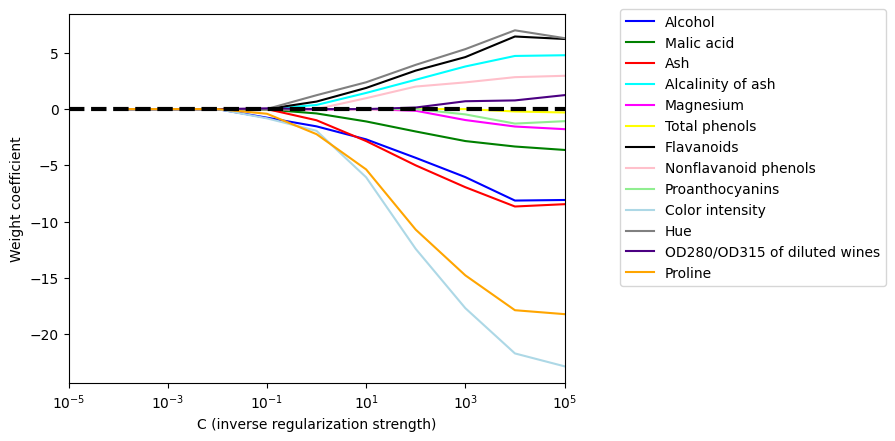

In [74]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear',
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

#plt.savefig('figures/04_08.png', dpi=300,
#            bbox_inches='tight', pad_inches=0.2)

plt.show()

## 순차 특성 선택 알고리즘


In [75]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

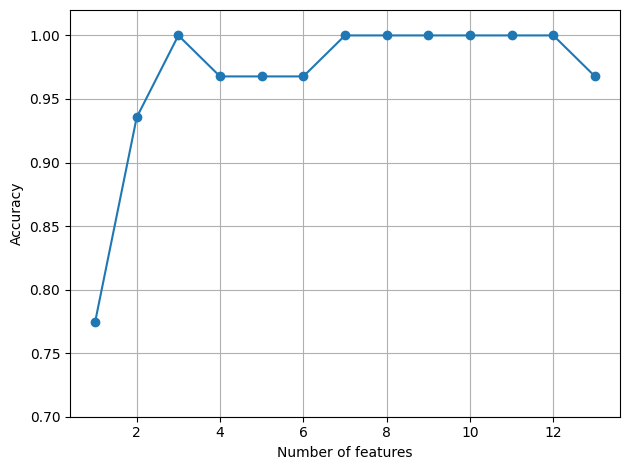

In [76]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# 특성을 선택합니다
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 선택한 특성의 성능을 출력합니다
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/04_09.png', dpi=300)
plt.show()

In [77]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [78]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [79]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


# 랜덤 포레스트의 특성 중요도 사용


 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


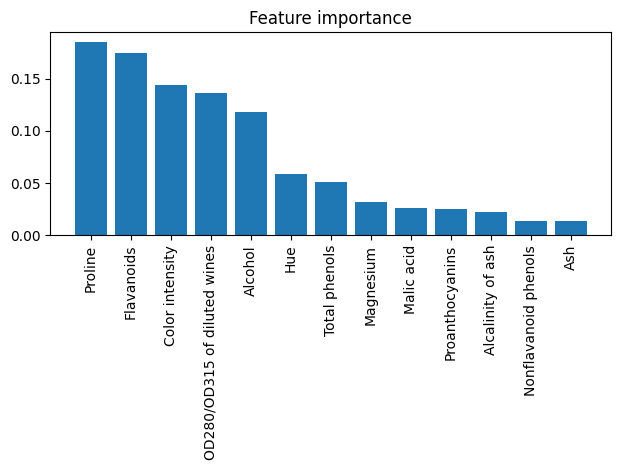

In [80]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()

In [81]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:',
      X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


앞서 지정한 특성 선택 임계 조건에 맞는 특성 5개를 출력해 보겠습니다:

In [82]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


<역주 코드>

---

In [83]:
from sklearn.feature_selection import RFE

rfe = RFE(forest, n_features_to_select=5)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=500, random_state=1),
    n_features_to_select=5)

In [84]:
rfe.ranking_

array([1, 5, 9, 6, 4, 3, 1, 8, 7, 1, 2, 1, 1])

In [85]:
f_mask = rfe.support_

In [96]:
importances = rfe.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

In [97]:
for i in range(5):
    print("%2d) %-*s %f" % (i + 1, 30,
                            feat_labels[f_mask][indices[i]],
                            importances[indices[i]]))

 1) Proline                        0.261512
 2) Color intensity                0.216477
 3) Flavanoids                     0.212259
 4) OD280/OD315 of diluted wines   0.188924
 5) Alcohol                        0.120828


---

# 요약